In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import glob
import statsmodels.api as sm
from scipy.stats import chi2, pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
from scipy.stats import linregress

font_size_title = 28
font_size_labels = 24
font_size_ticks = 20
marker_size = 10

In [4]:
### LOAD Local semantic entropy
df_filtered=pd.read_csv("./data/individual_entropy_filtered.csv")

### LOAD sunset sunrise timing
sun_df=pd.read_csv("./data/sunrise_sunset_per_city.csv")

### LOAD Global semantic entropy
file_list = glob.glob("./data/global_entropy_LOCAL_hour_DST*")
# Read and concatenate all files
df_list = [pd.read_csv(f) for f in file_list]
global_df = pd.concat(df_list, ignore_index=True)

# Ensure month is integer
global_df['month'] = global_df['month'].astype(int)
global_df

,month,loc_country,local_hour,global_entropy,n_posts
0,1,Algeria,19,-4163.853774,10
1,1,Argentina,0,-4125.908021,18
2,1,Argentina,1,-4126.703552,18
3,1,Argentina,3,-4164.805424,10
4,1,Argentina,9,-4144.958445,14
...,...,...,...,...,...
16662,12,Viet Nam,19,-4145.549309,14
16663,12,Viet Nam,20,-4097.959761,37
16664,12,Viet Nam,21,-4143.969823,22
16665,12,Viet Nam,22,-4155.014544,12


In [5]:
# Count posts per country
country_counts = (
    df_filtered["loc_country"]
    .value_counts()
    .head(5)
)

# Print results
for country, n_posts in country_counts.items():
    print(f"{country}: {n_posts} posts")

# Optional: total posts in top 5 countries
total_posts = country_counts.sum()
print(f"Total posts in top 5 countries: {total_posts}")

top5_df = (
    df_filtered["loc_country"]
    .value_counts()
    .head(5)
    .reset_index()
)
top5_df.columns = ["loc_country", "n_posts"]

top5_df

United States: 1739146 posts
India: 458776 posts
United Kingdom: 385138 posts
Canada: 338302 posts
Australia: 195699 posts
Total posts in top 5 countries: 3117061


,loc_country,n_posts
0,United States,1739146
1,India,458776
2,United Kingdom,385138
3,Canada,338302
4,Australia,195699


In [6]:
# Define top 4 countries (based on your previous analyses)
countries_to_plot = ["United States", "India", "United Kingdom", "Canada"]

# Compute number of posts per country
for country in countries_to_plot:
    n_posts = len(df_filtered[df_filtered['loc_country'] == country])
    print(f"{country}: {n_posts} posts")

total_posts = df_filtered[df_filtered['loc_country'].isin(countries_to_plot)].shape[0]
print(f"Total posts in top 4 countries: {total_posts}")

United States: 1739146 posts
India: 458776 posts
United Kingdom: 385138 posts
Canada: 338302 posts
Total posts in top 4 countries: 2921362


In [7]:
def cosinor_24h_mean(t, y):
    """
    Single-component 24-hour cosinor model
    using mean per hour instead of all individual datapoints.
    """
    omega = 2 * np.pi / 24

    X_full = np.column_stack([
        np.ones(len(t)),
        np.cos(omega * t),
        np.sin(omega * t)
    ])
    X_null = np.ones((len(t), 1))

    model_full = sm.OLS(y, X_full).fit()
    model_null = sm.OLS(y, X_null).fit()

    # Likelihood-ratio test
    lr_stat = 2 * (model_full.llf - model_null.llf)
    p_value = chi2.sf(lr_stat, df=2)

    beta_cos, beta_sin = model_full.params[1], model_full.params[2]
    amplitude = np.sqrt(beta_cos**2 + beta_sin**2)

    # Correct phase calculation
    phase = (24 / (2 * np.pi)) * np.arctan2(beta_sin, beta_cos)
    phase = phase % 24

    # R-squared
    r_squared = model_full.rsquared

    return {
        "amplitude": amplitude,
        "phase_h": phase,
        "p_value": p_value,
        "r_squared": r_squared,
        "model": model_full
    }

# ============================================================
# 2. Run cosinor per country using hourly means
# ============================================================

countries_to_plot = ["United States", "India", "United Kingdom", "Canada"]
results = []

for country in countries_to_plot:
    sub = df_filtered[df_filtered['loc_country'] == country].dropna(subset=['local_hour', 'individual_entropy'])

    # Compute mean per hour
    mean_per_hour = sub.groupby('local_hour')['individual_entropy'].mean()
    t_mean = mean_per_hour.index.values
    y_mean = mean_per_hour.values

    # Fit cosinor on hourly means
    res = cosinor_24h_mean(t_mean, y_mean)

    results.append({
        "country": country,
        "n_hours": len(y_mean),
        "amplitude": res["amplitude"],
        "phase_h": res["phase_h"],
        "p_value": res["p_value"],
        "r_squared": res["r_squared"]
    })

res_df = pd.DataFrame(results)

# Multiple-comparison correction
res_df["p_fdr"] = sm.stats.multipletests(res_df["p_value"], method="fdr_bh")[1]

print(res_df)
res_df.to_csv("local_entropy_hourly_mean_cosinor.csv", index=False)

          country  n_hours  amplitude   phase_h       p_value  r_squared  \
0   United States       24   0.067035  3.094764  5.843421e-08   0.750413   
1           India       24   0.074287  4.979027  1.040010e-07   0.738130   
2  United Kingdom       24   0.036152  4.197939  1.884034e-08   0.772879   
3          Canada       24   0.063245  3.159026  1.624896e-08   0.775662   

          p_fdr  
0  7.791227e-08  
1  1.040010e-07  
2  3.768067e-08  
3  3.768067e-08  


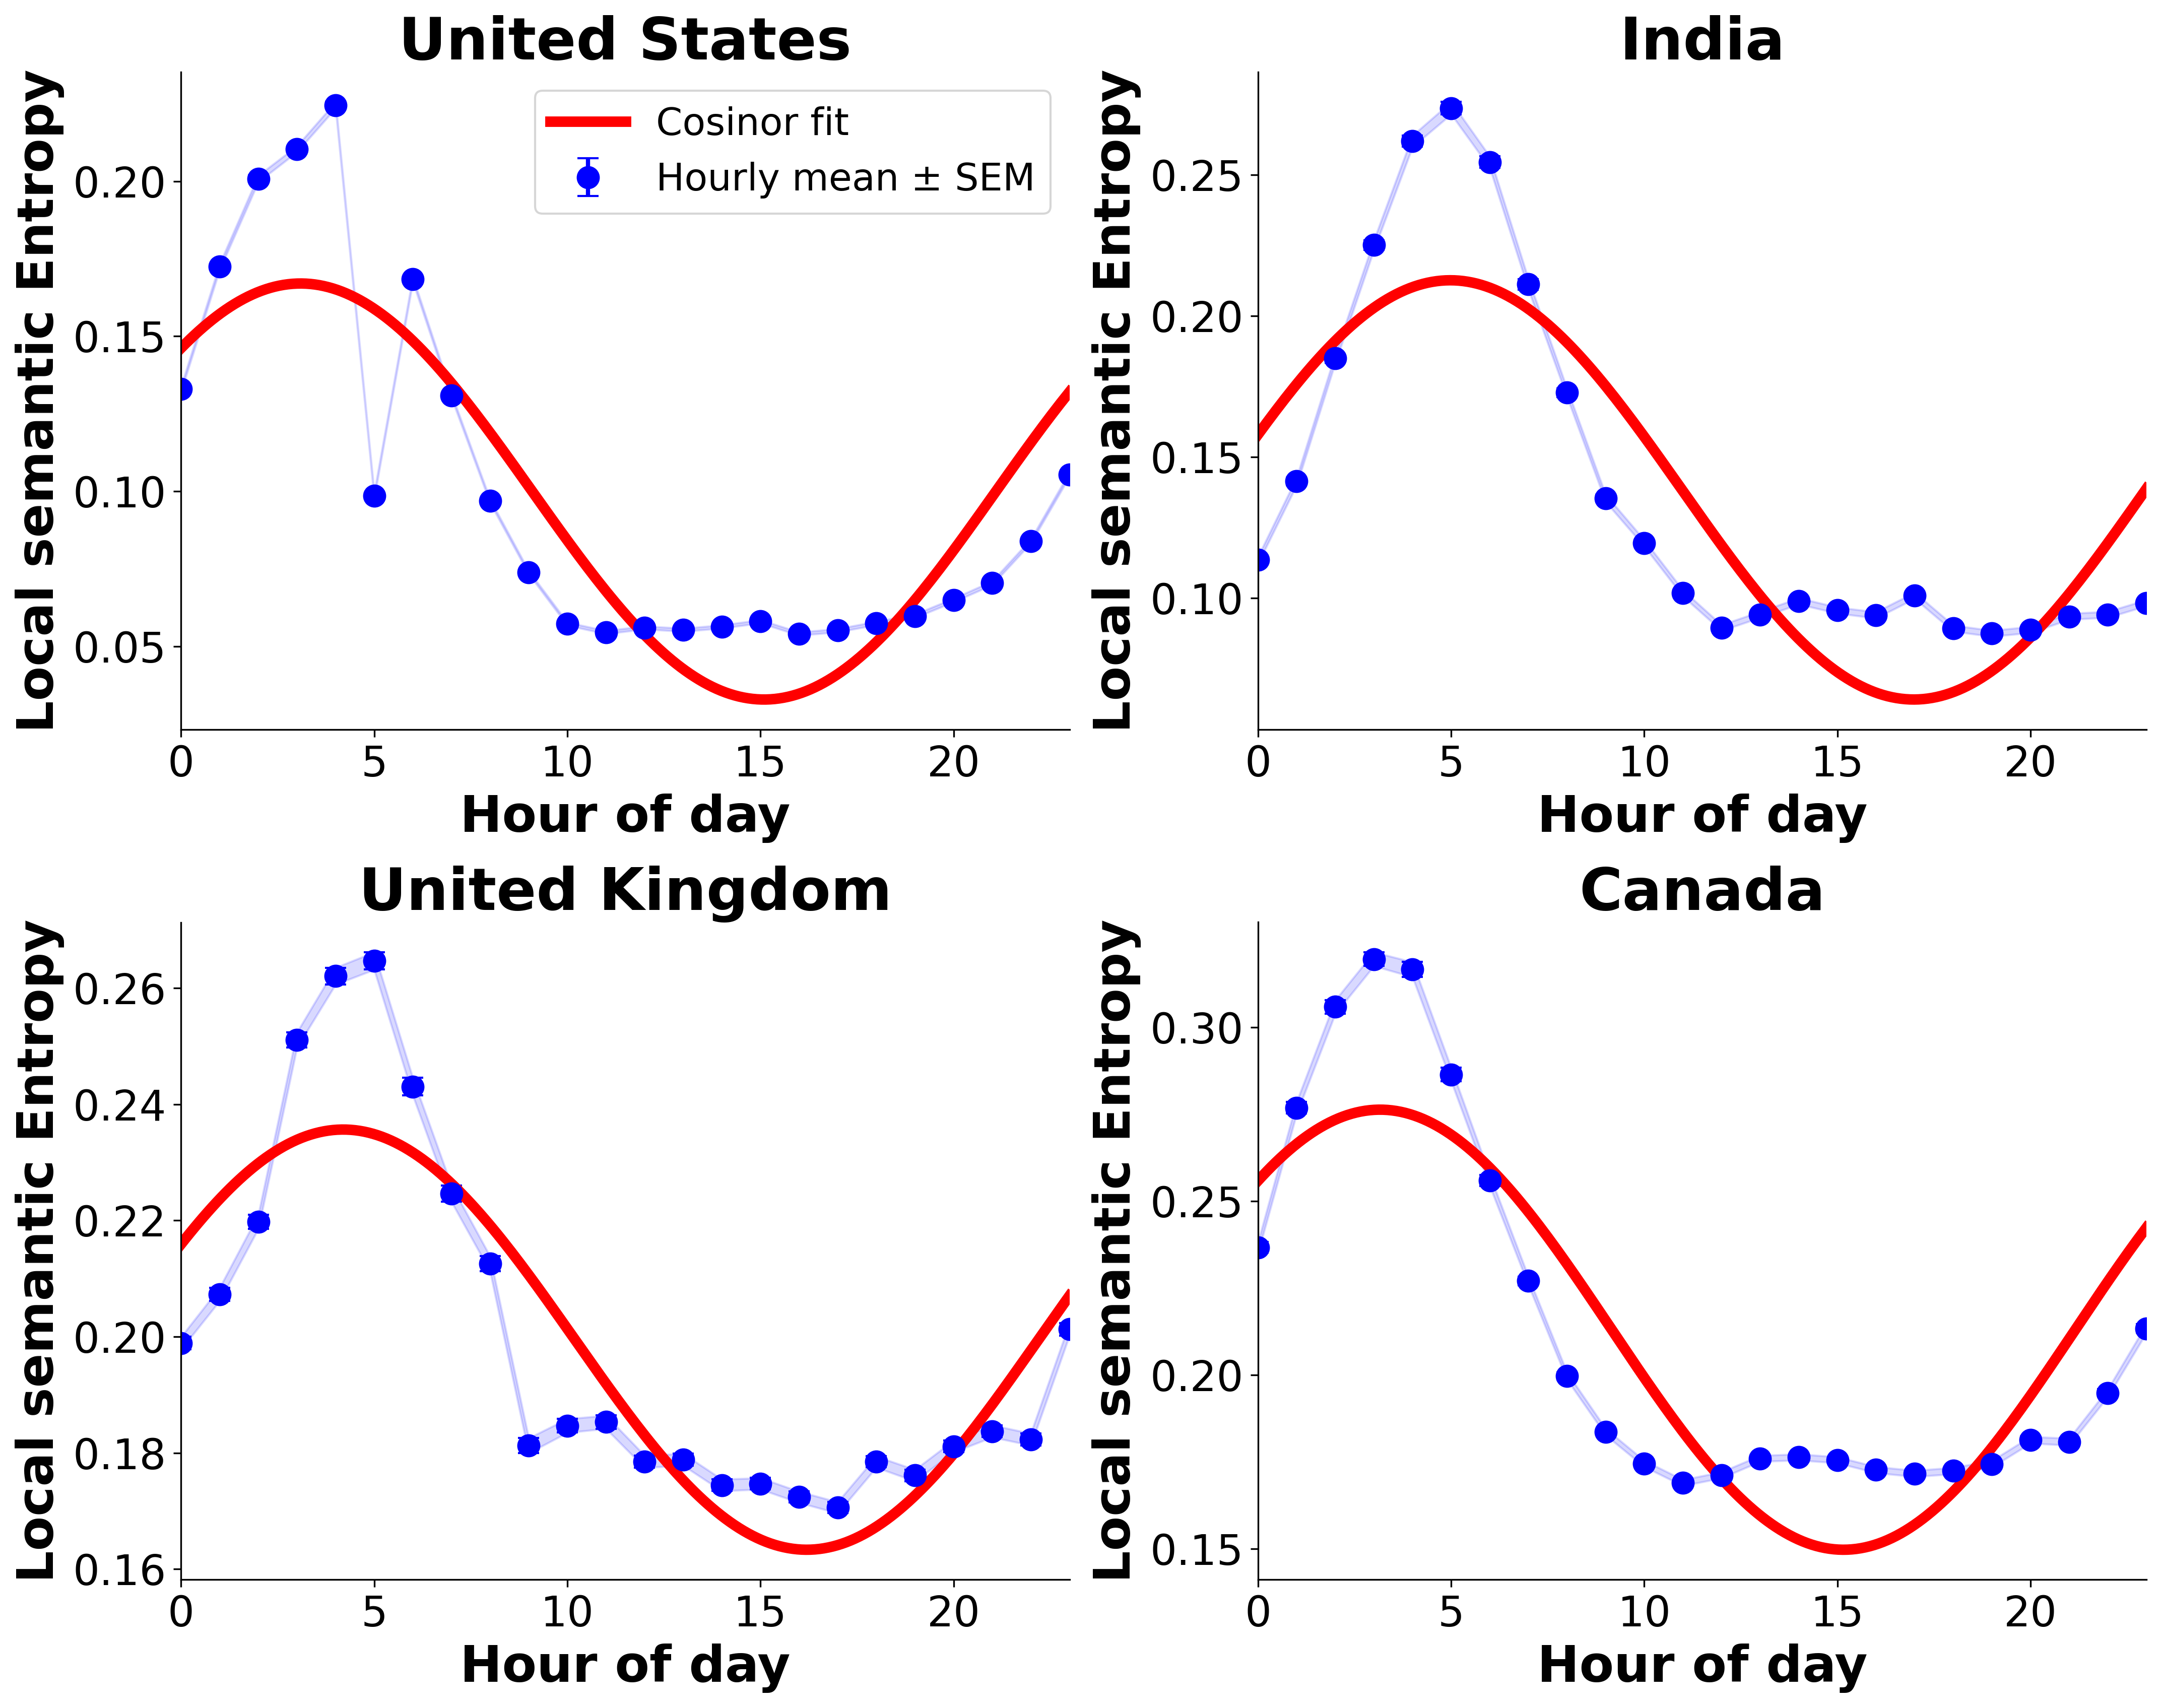

In [8]:
# ------------------------------------------------------------
# 2x2 figure for all countries (hourly mean with SEM)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=300)
axes = axes.flatten()

for i, country in enumerate(countries_to_plot):
    sub = df_filtered[df_filtered['loc_country'] == country].dropna(subset=['local_hour', 'individual_entropy'])

    # Aggregate per hour: mean ± SEM
    df_hourly = sub.groupby('local_hour')['individual_entropy'].agg(['mean', 'sem']).reset_index()
    t_hourly = df_hourly['local_hour'].values
    y_mean = df_hourly['mean'].values
    y_sem = df_hourly['sem'].values

    # Fit cosinor on hourly means
    omega = 2 * np.pi / 24
    X_hourly = np.column_stack([
        np.ones(len(t_hourly)),
        np.cos(omega * t_hourly),
        np.sin(omega * t_hourly)
    ])
    model_hourly = sm.OLS(y_mean, X_hourly).fit()

    # Plot means with SEM and cosinor fit
    hours_smooth = np.linspace(0, 23, 200)
    X_smooth = np.column_stack([
        np.ones(len(hours_smooth)),
        np.cos(omega * hours_smooth),
        np.sin(omega * hours_smooth)
    ])
    y_fit = model_hourly.predict(X_smooth)

    ax = axes[i]
    ax.errorbar(t_hourly, y_mean, yerr=y_sem, fmt='o', color='blue',
                markersize=marker_size, capsize=5, elinewidth=2, label='Hourly mean ± SEM')
    ax.fill_between(t_hourly, y_mean - y_sem, y_mean + y_sem, color='blue', alpha=0.15)
    ax.plot(hours_smooth, y_fit, color='red', label='Cosinor fit', linewidth=5)

    ax.set_title(country, fontsize=font_size_title, fontweight='bold')
    ax.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight='bold')
    ax.set_ylabel("Local semantic Entropy", fontsize=font_size_labels, fontweight='bold')
    ax.set_xlim(0, 23)
    ax.tick_params(axis='both', labelsize=font_size_ticks)
    if i == 0:
        ax.legend(fontsize=font_size_ticks-2)
    sns.despine()

plt.tight_layout(rect=[0, 0.05, 0.9, 1])
plt.savefig("Figure1.png")

C:\Users\user\AppData\Local\Temp\ipykernel_19440\3343670253.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


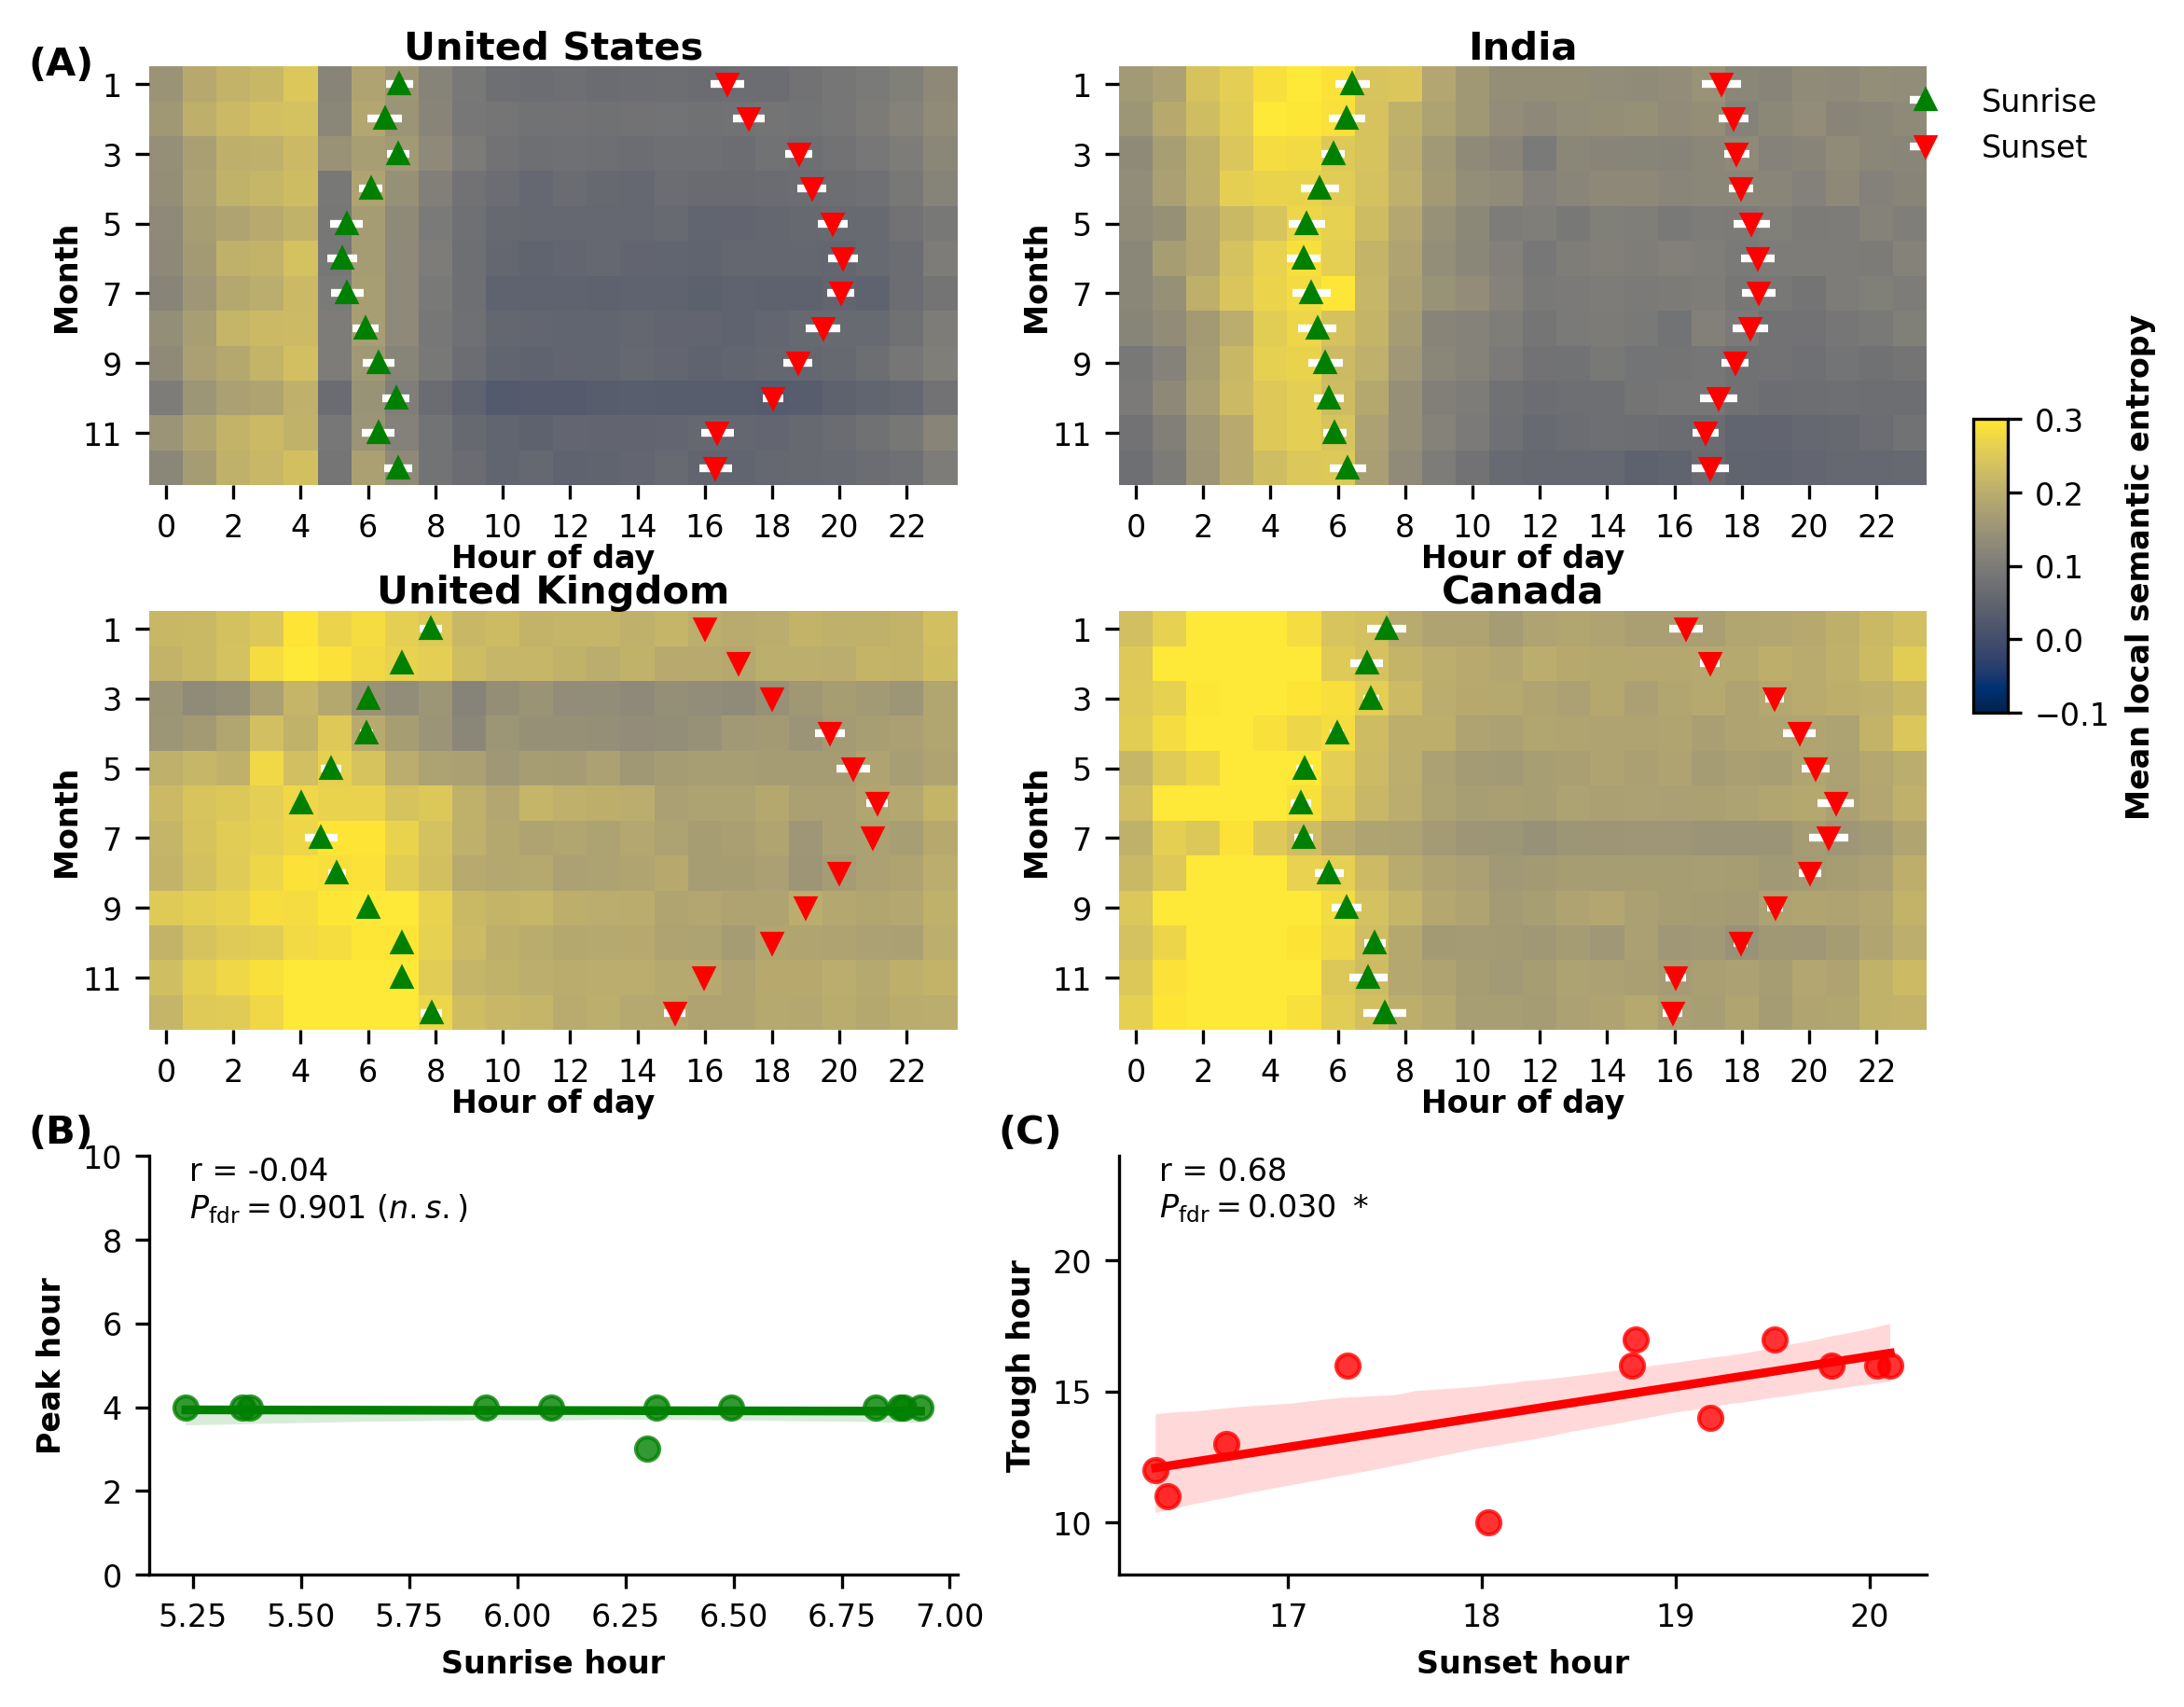

In [9]:
# ----------------------------
# Settings
# ----------------------------
countries_to_plot = ["United States", "India", "United Kingdom", "Canada"]
vmin, vmax = -0.1, 0.3
font_size_title = 10
font_size_labels = 8
font_size_ticks = 8
marker_size = 5
label_fontsize = 10  # panel labels

# ----------------------------
# Create figure with gridspec
# ----------------------------
fig = plt.figure(figsize=(8.2, 7), dpi=300)
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.3)

# ----------------------------
# Panel A: Heatmaps (first two rows, span all columns)
# ----------------------------
axes_A = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
          fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

for i, country in enumerate(countries_to_plot):
    ax = axes_A[i]
    sub = df_filtered[df_filtered['loc_country'] == country]

    heatmap_data = sub.groupby(['month', 'local_hour'])['individual_entropy'].mean().unstack()

    sun_stats = sun_df[sun_df.loc_country == country].groupby('month').agg({
        'sunrise_hour': ['mean', 'std'],
        'sunset_hour': ['mean', 'std']
    }).reset_index()
    sun_stats.columns = ['month', 'sunrise_mean', 'sunrise_std', 'sunset_mean', 'sunset_std']

    # Heatmap
    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="cividis",
        linewidths=0,
        vmin=vmin, vmax=vmax,
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )

    # Overlay sunrise/sunset
    for _, sun_row in sun_stats.iterrows():
        month = sun_row['month']
        ax.errorbar(
            sun_row['sunrise_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunrise_std'] if not np.isnan(sun_row['sunrise_std']) else 0,
            fmt='^',
            color='green',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunrise' if month == 1 else ""
        )
        ax.errorbar(
            sun_row['sunset_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunset_std'] if not np.isnan(sun_row['sunset_std']) else 0,
            fmt='v',
            color='red',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunset' if month == 1 else ""
        )

    # Titles & labels
    ax.set_title(f"{country}", fontsize=font_size_title, fontweight='bold', pad=0)
    ax.set_ylabel("Month", fontsize=font_size_labels, fontweight='bold', labelpad=0)
    ax.set_yticks(np.arange(0.5, 12.5, 2))
    ax.set_yticklabels(range(1, 13, 2), rotation=0, fontsize=font_size_ticks)
    ax.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight='bold', labelpad=0)
    ax.set_xticks(np.arange(0.5, 24.5, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=0, fontsize=font_size_ticks)

# Panel label (A) - span top left of first heatmap
axes_A[0].text(-0.15, 1.05, "(A)", transform=axes_A[0].transAxes,
               fontsize=label_fontsize, fontweight='bold', va='top')

# Single colorbar for all heatmaps
cbar_ax = fig.add_axes([0.92, 0.55, 0.015, 0.15])
smo = plt.cm.ScalarMappable(cmap="cividis", norm=plt.Normalize(vmin=vmin, vmax=vmax))
smo.set_array([])
cbar = fig.colorbar(smo, cax=cbar_ax)
cbar.set_label('Mean local semantic entropy', fontsize=font_size_labels, fontweight='bold')
cbar.ax.tick_params(labelsize=font_size_ticks)

# Legend for sunrise/sunset
legend_ax = fig.add_axes([0.92, 0.8, 0.02, 0.1])
handles, labels = axes_A[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, frameon=False, fontsize=font_size_labels, loc='center')
legend_ax.axis('off')

# ----------------------------
# Panel B & C: Scatter plots (3rd row)
# ----------------------------
axB = fig.add_subplot(gs[2, 0])
axC = fig.add_subplot(gs[2, 1])

# Example for United States
country = "United States"
sub = df_filtered[df_filtered['loc_country'] == country]
heatmap_data = sub.groupby(['month', 'local_hour'])['individual_entropy'].mean().unstack()

# Peak / trough
peak_hour, trough_hour = [], []
for month in range(1, 13):
    row = heatmap_data.loc[month].values
    if np.all(np.isnan(row)):
        peak_hour.append(np.nan)
        trough_hour.append(np.nan)
    else:
        peak_hour.append(np.nanargmax(row))
        trough_hour.append(np.nanargmin(row))
peak_array = np.array(peak_hour)
trough_array = np.array(trough_hour)

# Sunrise / sunset
sun_stats = sun_df[sun_df['loc_country'] == country].groupby('month')[['sunrise_hour', 'sunset_hour']].mean().reindex(range(1,13))
sunrise_array = sun_stats['sunrise_hour'].values
sunset_array = sun_stats['sunset_hour'].values

# Masks
mask_peak = ~np.isnan(peak_array) & ~np.isnan(sunrise_array)
mask_trough = ~np.isnan(trough_array) & ~np.isnan(sunset_array)

# Prepare FDR-corrected p-values
r_values, p_values = [], []
if mask_peak.sum() >= 3:
    r, p = pearsonr(peak_array[mask_peak], sunrise_array[mask_peak])
    r_values.append(r); p_values.append(p)
if mask_trough.sum() >= 3:
    r, p = pearsonr(trough_array[mask_trough], sunset_array[mask_trough])
    r_values.append(r); p_values.append(p)

# FDR correction
reject, pvals_fdr, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Panel B: Peak vs Sunrise
if mask_peak.sum() >= 3:
    sns.regplot(x=sunrise_array[mask_peak], y=peak_array[mask_peak], color='green', ax=axB)
    sig = "*" if reject[0] else "(n.s.)"
    axB.text(
        0.05, 1,
        rf"r = {r_values[0]:.2f}" + "\n" +  # raw f-string
        rf"$P_{{\mathrm{{fdr}}}} = {pvals_fdr[0]:.3f} \ {sig}$",
        transform=axB.transAxes,
        va='top',
        fontsize=font_size_ticks
    )
# axB.set_title("Peak vs Sunrise (US)", fontsize=font_size_title, fontweight='bold')
axB.set_xlabel("Sunrise hour", fontsize=font_size_labels, fontweight='bold')
axB.set_ylabel("Peak hour", fontsize=font_size_labels, fontweight='bold')
axB.tick_params(labelsize=font_size_ticks)
sns.despine(ax=axB)
axB.set_ylim(0, 10)  # Adjust y-limit to remove extreme outlier
axB.text(-0.15, 1.1, "(B)", transform=axB.transAxes, fontsize=label_fontsize, fontweight='bold', va='top')

# Panel C: Trough vs Sunset
if mask_trough.sum() >= 3:
    sns.regplot(x=sunset_array[mask_trough], y=trough_array[mask_trough], color='red', ax=axC)
    sig = "*" if reject[1] else "(n.s)."
    axC.text(
        0.05, 1,
        rf"r = {r_values[1]:.2f}" + "\n" +  # raw f-string
        rf"$P_{{\mathrm{{fdr}}}} = {pvals_fdr[1]:.3f} \ {sig}$",
        transform=axC.transAxes,
        va='top',
        fontsize=font_size_ticks
    )
# axC.set_title("Trough vs Sunset (US)", fontsize=font_size_title, fontweight='bold')
axC.set_xlabel("Sunset hour", fontsize=font_size_labels, fontweight='bold')
axC.set_ylabel("Trough hour", fontsize=font_size_labels, fontweight='bold')
axC.tick_params(labelsize=font_size_ticks)
sns.despine(ax=axC)
axC.set_ylim(8, 24)   # Adjust y-limit to remove extreme outlier
axC.text(-0.15, 1.1, "(C)", transform=axC.transAxes, fontsize=label_fontsize, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig("Figure2.png")

In [ ]:
posemo_df=pd.read_csv("./data/extracted_posemo.csv")
sadness_df=pd.read_csv("./data/extracted_sadness.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'extracted_posemo.csv'

In [ ]:
uk = df_filtered[df_filtered["loc_country"] == "United Kingdom"]

# Example: aggregate by hour
uk_hourly = (
    uk.groupby("local_hour")
      .agg(
          semantic_entropy=("individual_entropy", "mean"),
          sentiment_mean=("sentiment_compound", "mean"),
          sentiment_sem=("sentiment_compound", "sem")
      )
      .dropna()
      .reset_index()
)

# # Example: aggregate by hour
# uk_hourly = (
#     uk.groupby("local_hour")
#       .agg(
#           sentiment_mean=("sentiment_compound", "mean"),
#           sentiment_sem=("sentiment_compound", "sem")
#       )
#       .dropna()
#       .reset_index()
# )


# Prepare UK entropy
uk_entropy = (
    uk_hourly
    .reset_index()
    .rename(columns={"local_hour": "hour"})
    [["hour", "semantic_entropy"]]
)


In [ ]:

# # Merge all signals
# df_plot = (
#     uk_entropy
#     .merge(posemo_df[["hour", "SD"]].rename(columns={"SD": "posemo_SD"}), on="hour")
#     .merge(sadness_df[["hour", "SD"]].rename(columns={"SD": "sadness_SD"}), on="hour")
# )

# fig, ax1 = plt.subplots(figsize=(6,4), dpi=300)

# # Left axis: semantic entropy
# ax1.plot(
#     df_plot["hour"],
#     df_plot["semantic_entropy"],
#     label="Local semantic entropy", color="k",
#     linewidth=2
# )
# ax1.set_ylabel("Local semantic entropy")
# ax1.set_xlabel("Hour of day")
# ax1.tick_params(axis="y")

# # Right axis: posemo + sadness variability
# ax2 = ax1.twinx()
# ax2.plot(
#     df_plot["hour"],
#     df_plot["posemo_SD"],
#     linestyle="--", color="red",
#     label="posemo SD"
# )
# ax2.plot(
#     df_plot["hour"],
#     df_plot["sadness_SD"],
#     linestyle=":", color="blue",
#     label="sadness SD"
# )
# ax2.set_ylabel("Word usage SD")

# # Legend (combine both axes)
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# plt.tight_layout()
# sns.despine()
# plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20180\111432580.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


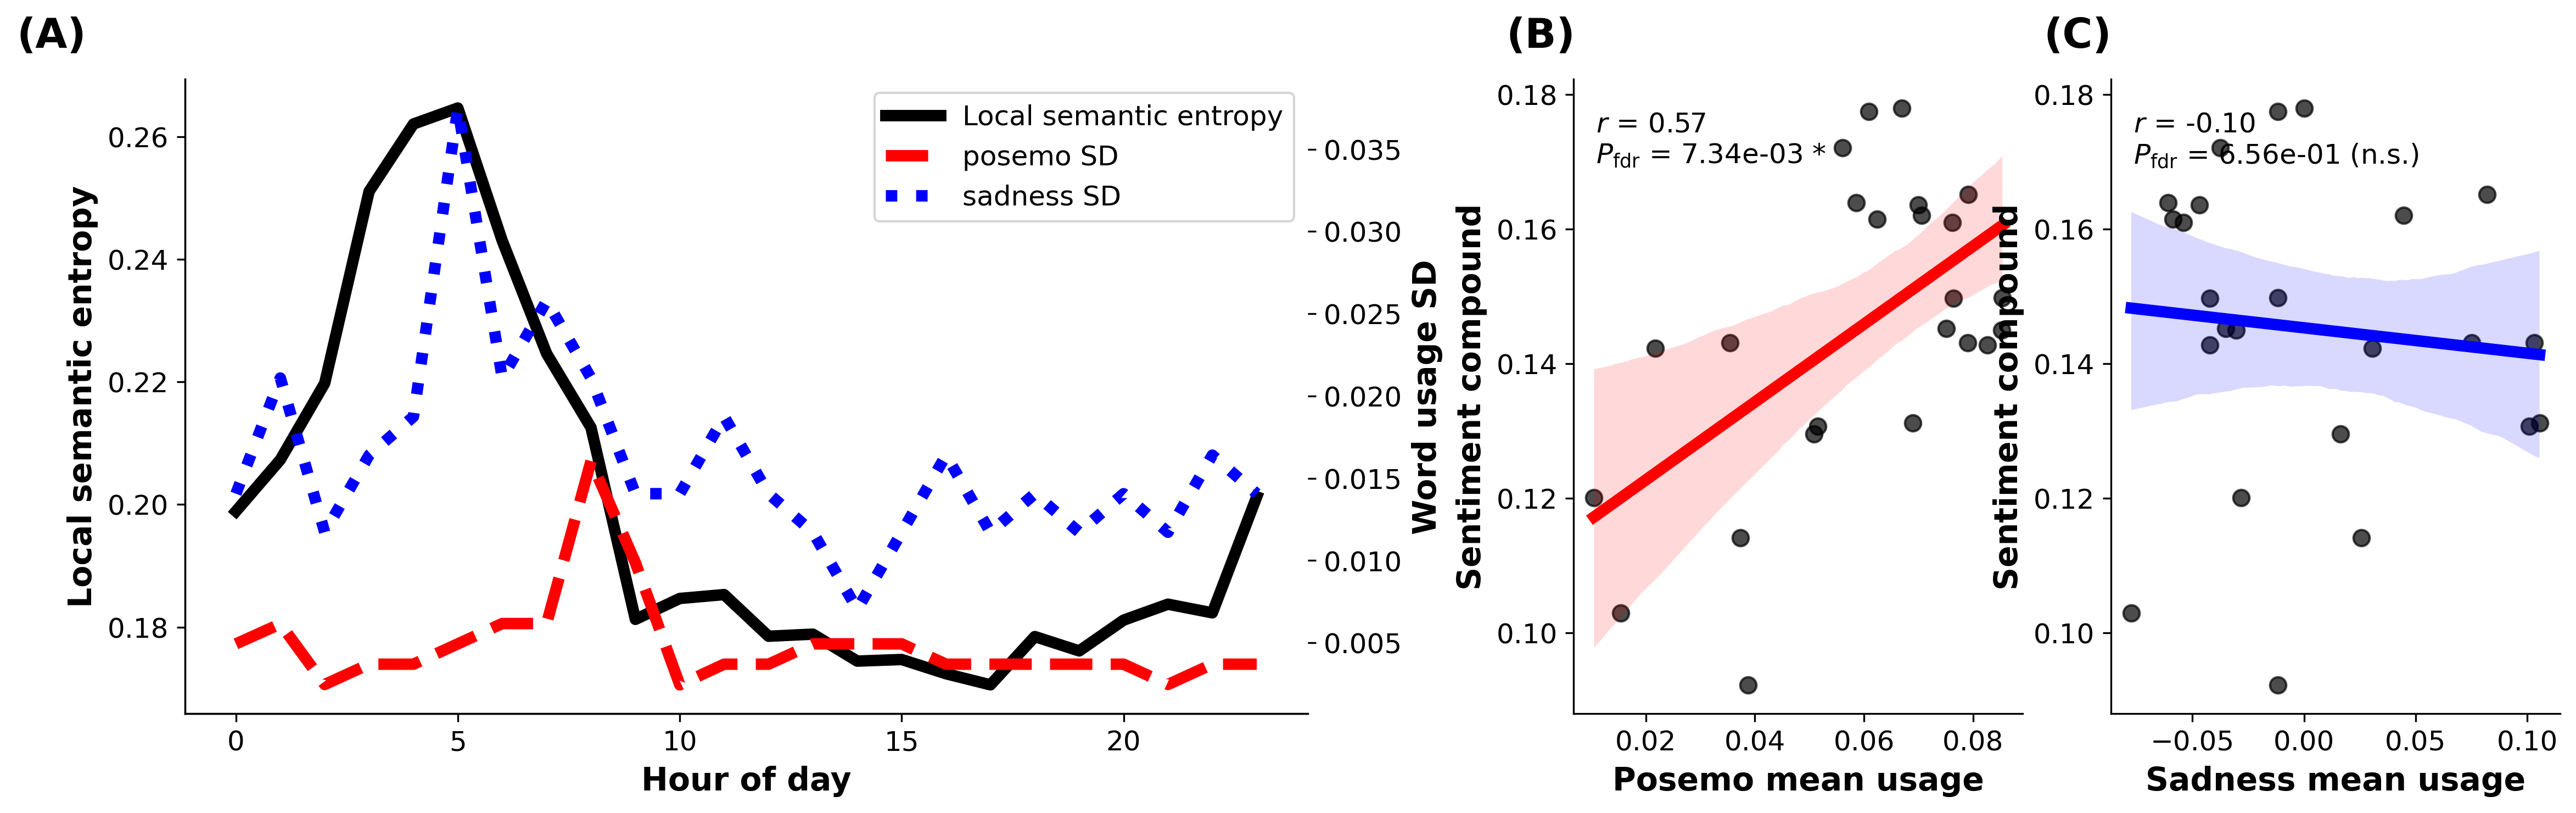

In [ ]:
# ----------------------------
# Panel settings
# ----------------------------
font_size_title = 16
font_size_labels = 14
font_size_ticks = 12
marker_size = 50
line_width = 5
panel_label_fontsize = 18

# ----------------------------
# Prepare figure
# ----------------------------
fig = plt.figure(figsize=(20, 5), dpi=300)
gs = gridspec.GridSpec(
    1, 5, figure=fig,
    width_ratios=[2.5, 0.2, 1, 1, 0.2],
    wspace=0.2
)

axA = fig.add_subplot(gs[0])  # Panel A
axB = fig.add_subplot(gs[2])  # Panel B
axC = fig.add_subplot(gs[3])  # Panel C

# ============================
# Panel A: Semantic entropy + posemo/sadness SD
# ============================
df_plot = (
    uk_entropy
    .merge(
        posemo_df[["hour", "SD"]].rename(columns={"SD": "posemo_SD"}),
        on="hour"
    )
    .merge(
        sadness_df[["hour", "SD"]].rename(columns={"SD": "sadness_SD"}),
        on="hour"
    )
)

# Left axis
axA.plot(
    df_plot["hour"], df_plot["semantic_entropy"],
    label="Local semantic entropy",
    color="k",
    linewidth=line_width
)
axA.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight="bold")
axA.set_ylabel("Local semantic entropy", fontsize=font_size_labels, fontweight="bold")
axA.tick_params(labelsize=font_size_ticks)

# Right axis
axA2 = axA.twinx()
axA2.plot(
    df_plot["hour"], df_plot["posemo_SD"],
    linestyle="--", color="red",
    linewidth=line_width, label="posemo SD"
)
axA2.plot(
    df_plot["hour"], df_plot["sadness_SD"],
    linestyle=":", color="blue",
    linewidth=line_width, label="sadness SD"
)
axA2.set_ylabel("Word usage SD", fontsize=font_size_labels, fontweight="bold")
axA2.tick_params(labelsize=font_size_ticks)

# Legend
lines1, labels1 = axA.get_legend_handles_labels()
lines2, labels2 = axA2.get_legend_handles_labels()
axA.legend(lines1 + lines2, labels1 + labels2,
           loc="upper right", fontsize=12)

axA.text(-0.15, 1.05, "(A)",
         transform=axA.transAxes,
         fontsize=panel_label_fontsize,
         fontweight="bold")

# ============================
# Panels B & C: correlations
# ============================
# --- Panel B ---
xB = posemo_df["mean_usage"].values
yB = uk_hourly["sentiment_mean"].values
rB, pB = pearsonr(xB, yB)

# --- Panel C ---
xC = sadness_df["mean_usage"].values
yC = uk_hourly["sentiment_mean"].values
rC, pC = pearsonr(xC, yC)

# ============================
# FDR correction (joint)
# ============================
pvals = [pB, pC]
reject, pvals_fdr, _, _ = multipletests(pvals, method="fdr_bh")

pB_fdr, pC_fdr = pvals_fdr
sigB = "*" if reject[0] else "(n.s)."
sigC = "*" if reject[1] else "(n.s.)"

# ============================
# Panel B plot
# ============================
sns.regplot(
    x=xB, y=yB, ax=axB,
    scatter_kws=dict(s=marker_size, alpha=0.7, color="k"),
    line_kws=dict(color="red", lw=line_width)
)

axB.set_xlabel("Posemo mean usage", fontsize=font_size_labels, fontweight="bold")
axB.set_ylabel("Sentiment compound", fontsize=font_size_labels, fontweight="bold")
axB.tick_params(labelsize=font_size_ticks)

axB.text(
    0.05, 0.95,
    f"$r$ = {rB:.2f}\n$P_{{\\mathrm{{fdr}}}}$ = {pB_fdr:.2e} {sigB}",
    transform=axB.transAxes,
    ha="left", va="top",
    fontsize=font_size_ticks
)

axB.text(-0.15, 1.05, "(B)",
         transform=axB.transAxes,
         fontsize=panel_label_fontsize,
         fontweight="bold")

# ============================
# Panel C plot
# ============================
sns.regplot(
    x=xC, y=yC, ax=axC,
    scatter_kws=dict(s=marker_size, alpha=0.7, color="k"),
    line_kws=dict(color="blue", lw=line_width)
)

axC.set_xlabel("Sadness mean usage", fontsize=font_size_labels, fontweight="bold")
axC.set_ylabel("Sentiment compound", fontsize=font_size_labels, fontweight="bold")
axC.tick_params(labelsize=font_size_ticks)

axC.text(
    0.05, 0.95,
    f"$r$ = {rC:.2f}\n$P_{{\\mathrm{{fdr}}}}$ = {pC_fdr:.2e} {sigC}",
    transform=axC.transAxes,
    ha="left", va="top",
    fontsize=font_size_ticks
)

axC.text(-0.15, 1.05, "(C)",
         transform=axC.transAxes,
         fontsize=panel_label_fontsize,
         fontweight="bold")

# ============================
# Final adjustments
# ============================
plt.tight_layout()
sns.despine()
plt.savefig("Fig4.png", bbox_inches="tight")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20180\760243341.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


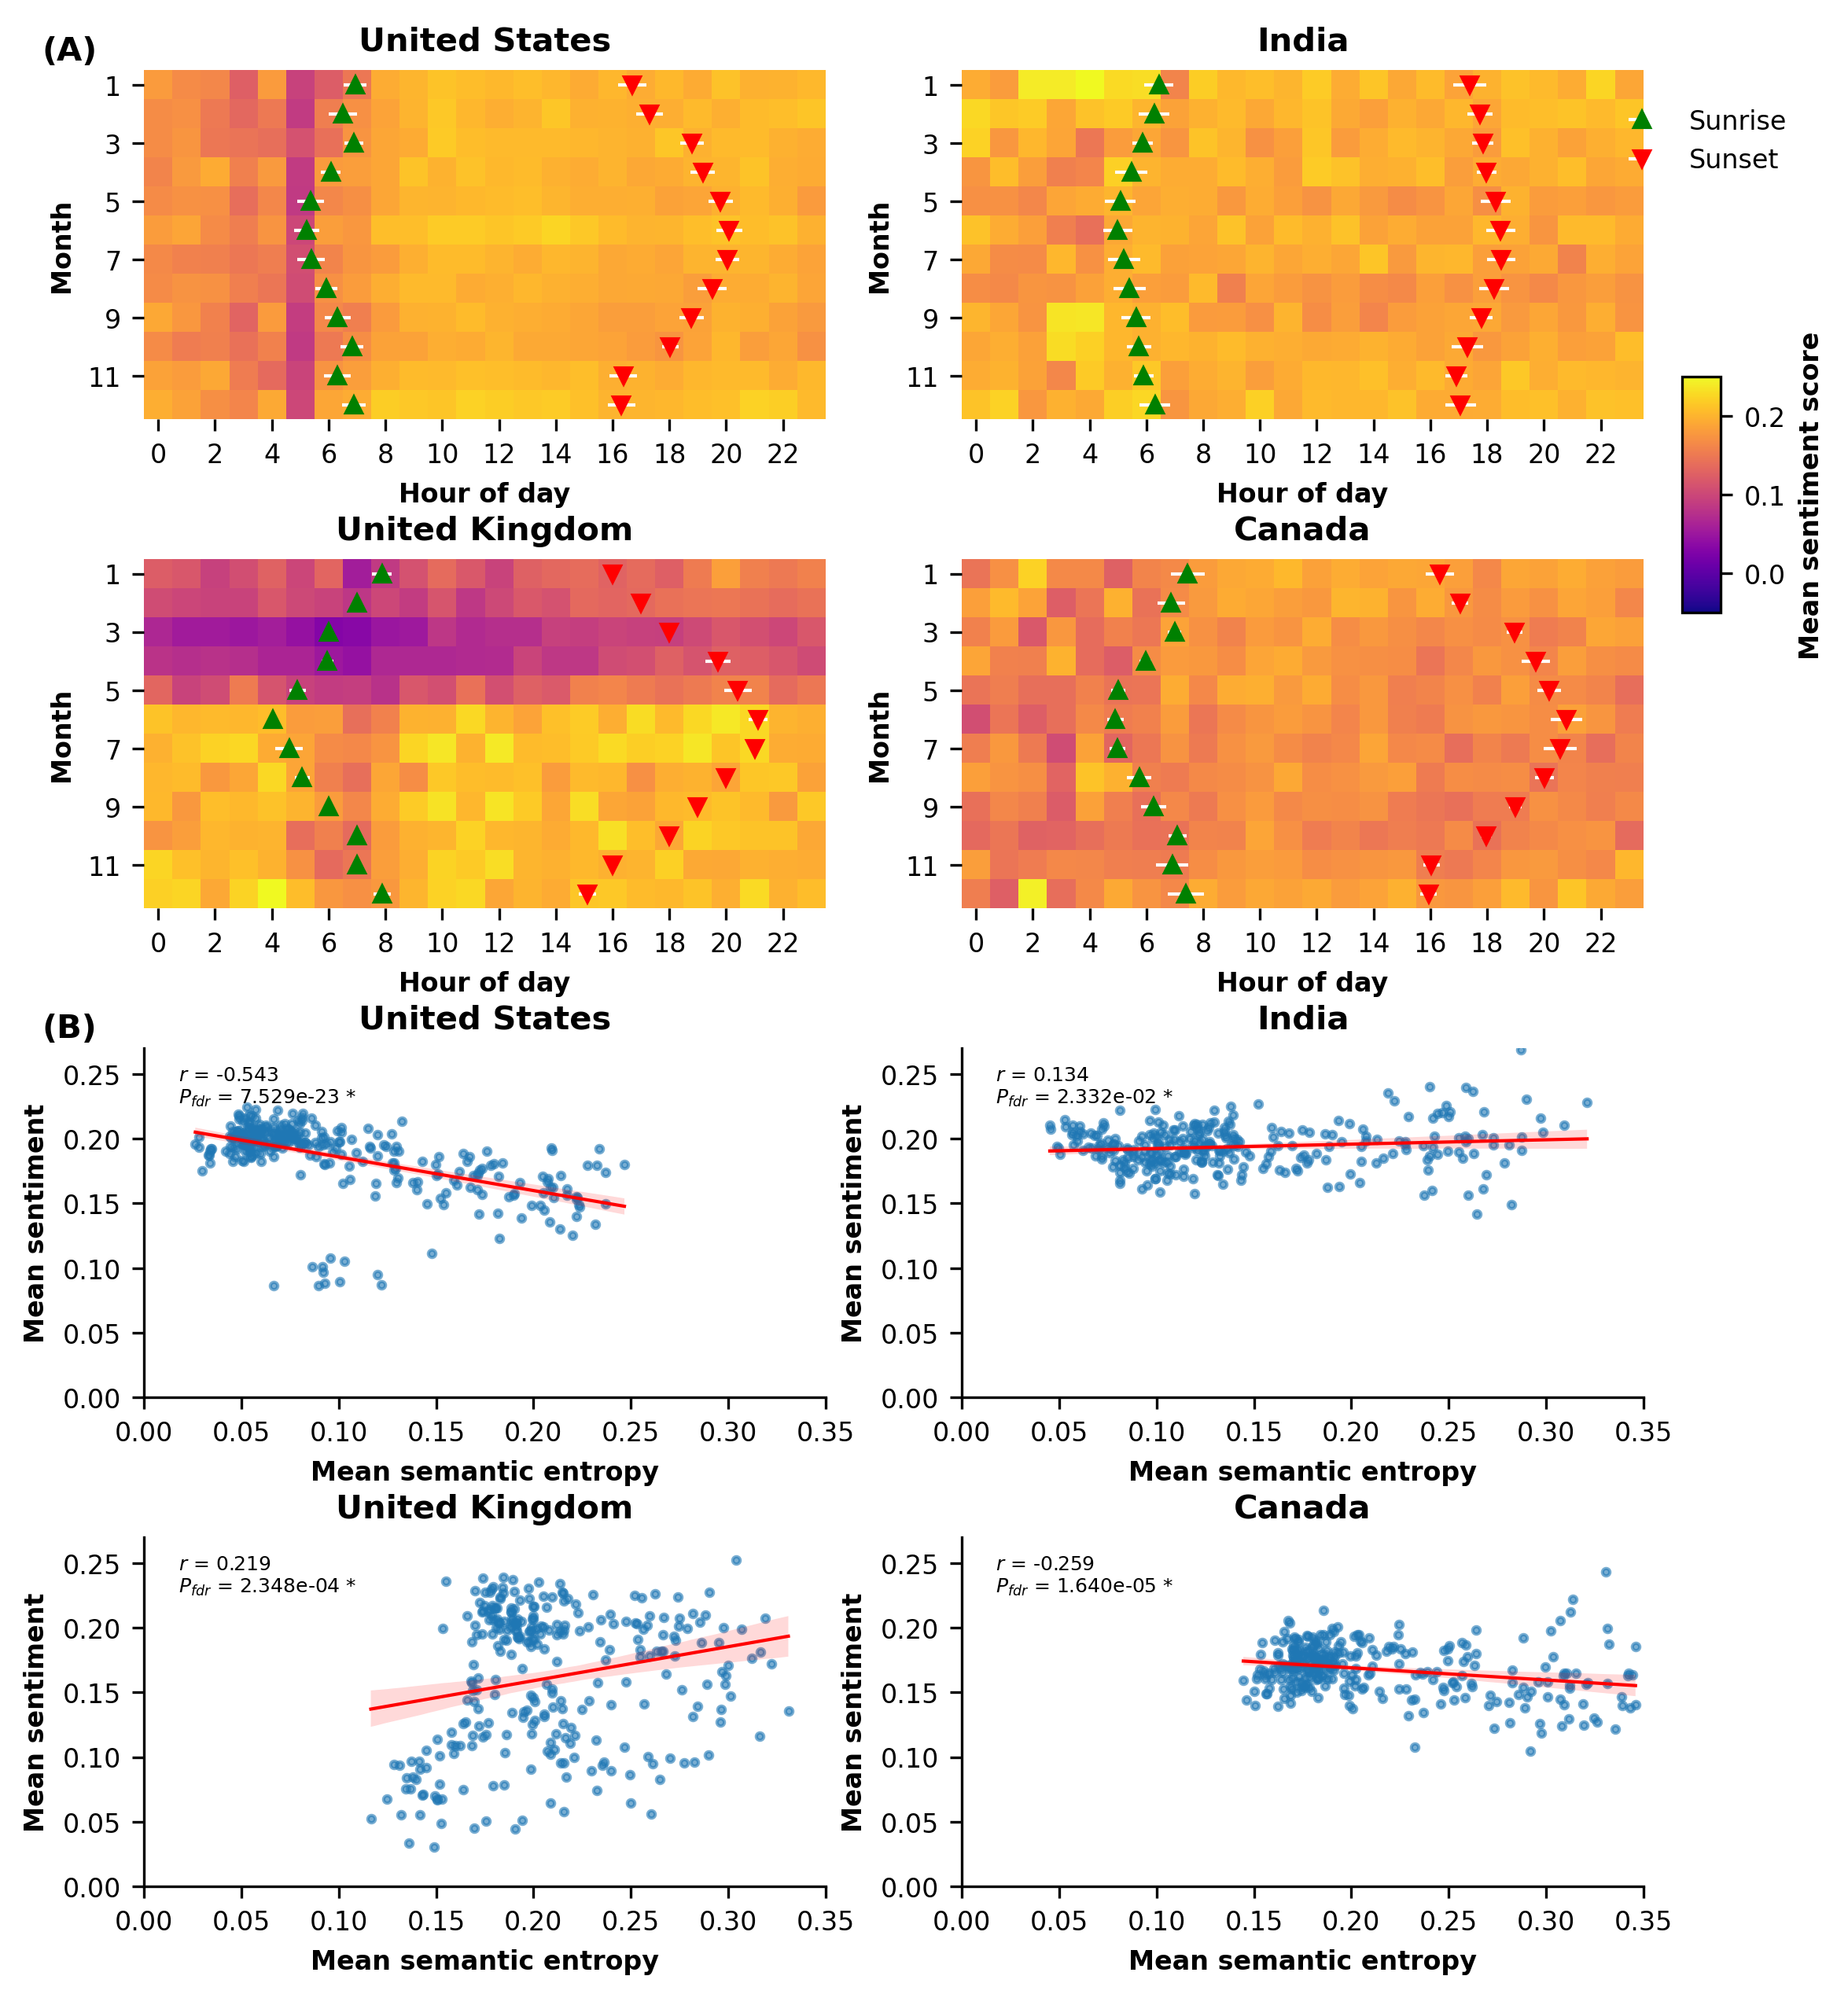

In [ ]:
# ----------------------------
# Settings
# ----------------------------
countries_to_plot = ["United States", "India", "United Kingdom", "Canada"]

vmin_sent, vmax_sent = -0.05, 0.25
line_width = 1    # regression line width
panel_label_fontsize = 10
font_size_title = 10
font_size_labels = 8
font_size_ticks = 8
marker_size = 5
label_fontsize = 10  # panel labels

# Combined figure: 4 rows, 2 columns
fig = plt.figure(figsize=(8.2, 10), dpi=300)
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1], hspace=0.4)  # 4 rows now

# Panel A: heatmaps (first 2 rows)
axes_A = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
          fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# Panel B: scatter plots (rows 3 and 4)
axes_B = [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
          fig.add_subplot(gs[3, 0]), fig.add_subplot(gs[3, 1])]

for i, country in enumerate(countries_to_plot):
    ax = axes_A[i]
    sub = df_filtered[df_filtered['loc_country'] == country]

    # Heatmap
    heatmap_data = sub.groupby(['month', 'local_hour'])['sentiment_compound'].mean().unstack()

    # Sunrise/sunset stats
    sun_stats = sun_df[sun_df.loc_country == country].groupby('month').agg({
        'sunrise_hour': ['mean', 'std'],
        'sunset_hour': ['mean', 'std']
    }).reset_index()
    sun_stats.columns = ['month', 'sunrise_mean', 'sunrise_std', 'sunset_mean', 'sunset_std']

    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="plasma",
        linewidths=0,
        vmin=vmin_sent, vmax=vmax_sent,
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )

    # Remove black frame around heatmaps
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Overlay sunrise/sunset
    for _, sun_row in sun_stats.iterrows():
        month = sun_row['month']
        ax.errorbar(
            sun_row['sunrise_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunrise_std'] if not np.isnan(sun_row['sunrise_std']) else 0,
            fmt='^', color='green', ecolor='white', elinewidth=line_width, markersize=marker_size,
            label='Sunrise' if month == 1 else ""
        )
        ax.errorbar(
            sun_row['sunset_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunset_std'] if not np.isnan(sun_row['sunset_std']) else 0,
            fmt='v', color='red', ecolor='white', elinewidth=line_width, markersize=marker_size,
            label='Sunset' if month == 1 else ""
        )

    ax.set_title(f"{country}", fontsize=font_size_title, fontweight='bold')
    ax.set_ylabel("Month", fontsize=font_size_labels, fontweight='bold')
    ax.set_yticks(np.arange(0.5, 12.5, 2))
    ax.set_yticklabels(range(1, 13, 2), rotation=0, fontsize=font_size_ticks)
    ax.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight='bold')
    ax.set_xticks(np.arange(0.5, 24.5, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=0, fontsize=font_size_ticks)

        # After setting title, labels, ticks
    for spine in ax.spines.values():
        spine.set_visible(False)

# Panel label (A)
axes_A[0].text(-0.15, 1.1, "(A)", transform=axes_A[0].transAxes,
               fontsize=panel_label_fontsize, fontweight='bold', va='top')

# Colorbar for heatmaps
cbar_ax = fig.add_axes([0.92, 0.65, 0.02, 0.1])
smo = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=vmin_sent, vmax=vmax_sent))
smo.set_array([])
cbar = fig.colorbar(smo, cax=cbar_ax)
cbar.set_label('Mean sentiment score', fontsize=font_size_labels, fontweight='bold')
cbar.ax.tick_params(labelsize=font_size_ticks)

# Legend for sunrise/sunset
legend_ax = fig.add_axes([0.92, 0.8, 0.02, 0.1])
handles, labels = axes_A[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, frameon=False, fontsize=font_size_labels, loc='center')
legend_ax.axis('off')

# ----------------------------
# Panel B: Scatter plots (with proper FDR)
# ----------------------------

results = []

# ---- First pass: compute correlations & raw p-values ----
for country in countries_to_plot:
    sub = df_filtered[df_filtered["loc_country"] == country]

    H_entropy = (
        sub.groupby(["month", "local_hour"])["individual_entropy"]
        .mean()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    H_sent = (
        sub.groupby(["month", "local_hour"])["sentiment_compound"]
        .mean()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    x = H_entropy.values.flatten()
    y = H_sent.values.flatten()
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    if len(x) < 20:
        results.append(dict(country=country, r=np.nan, p=np.nan))
        continue

    r, p = pearsonr(x, y)
    results.append(dict(country=country, r=r, p=p))

results_df = pd.DataFrame(results)

# ---- FDR correction across COUNTRIES ----
valid = results_df["p"].notna()
results_df.loc[valid, "p_fdr"] = multipletests(
    results_df.loc[valid, "p"],
    method="fdr_bh"
)[1]

# ---- Second pass: plotting ----
for ax, country in zip(axes_B, countries_to_plot):
    sub = df_filtered[df_filtered["loc_country"] == country]

    H_entropy = (
        sub.groupby(["month", "local_hour"])["individual_entropy"]
        .mean()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    H_sent = (
        sub.groupby(["month", "local_hour"])["sentiment_compound"]
        .mean()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    x = H_entropy.values.flatten()
    y = H_sent.values.flatten()
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    res = results_df[results_df.country == country].iloc[0]

    if len(x) < 20:
        ax.axis("off")
        ax.set_title(f"{country}\n(not enough data)")
        continue

    sig = "*" if res["p_fdr"] < 0.05 else "(n.s.)"

    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        scatter_kws=dict(s=marker_size, alpha=0.6),
        line_kws=dict(color="red", lw=line_width),
        ci=95
    )

    ax.set_title(country, fontsize=font_size_title, fontweight="bold")
    ax.set_xlabel("Mean semantic entropy", fontsize=font_size_labels, fontweight="bold")
    ax.set_ylabel("Mean sentiment", fontsize=font_size_labels, fontweight="bold")
    ax.tick_params(labelsize=font_size_ticks)

    ax.text(
        0.05, 0.95,
        f"$r$ = {res['r']:.3f}\n"
        f"$P_{{fdr}}$ = {res['p_fdr']:.3e} {sig}",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=font_size_ticks - 2
    )
    ax.set_xlim(0,0.35)
    ax.set_ylim(0,0.27)
    sns.despine(ax=ax)

# Panel label for B
axes_B[0].text(
    -0.15, 1.1, "(B)",
    transform=axes_B[0].transAxes,
    fontsize=panel_label_fontsize,
    fontweight="bold",
    va="top"
)

plt.tight_layout()
plt.savefig("Figure3.png")

C:\Users\user\AppData\Local\Temp\ipykernel_20180\197132553.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 1])


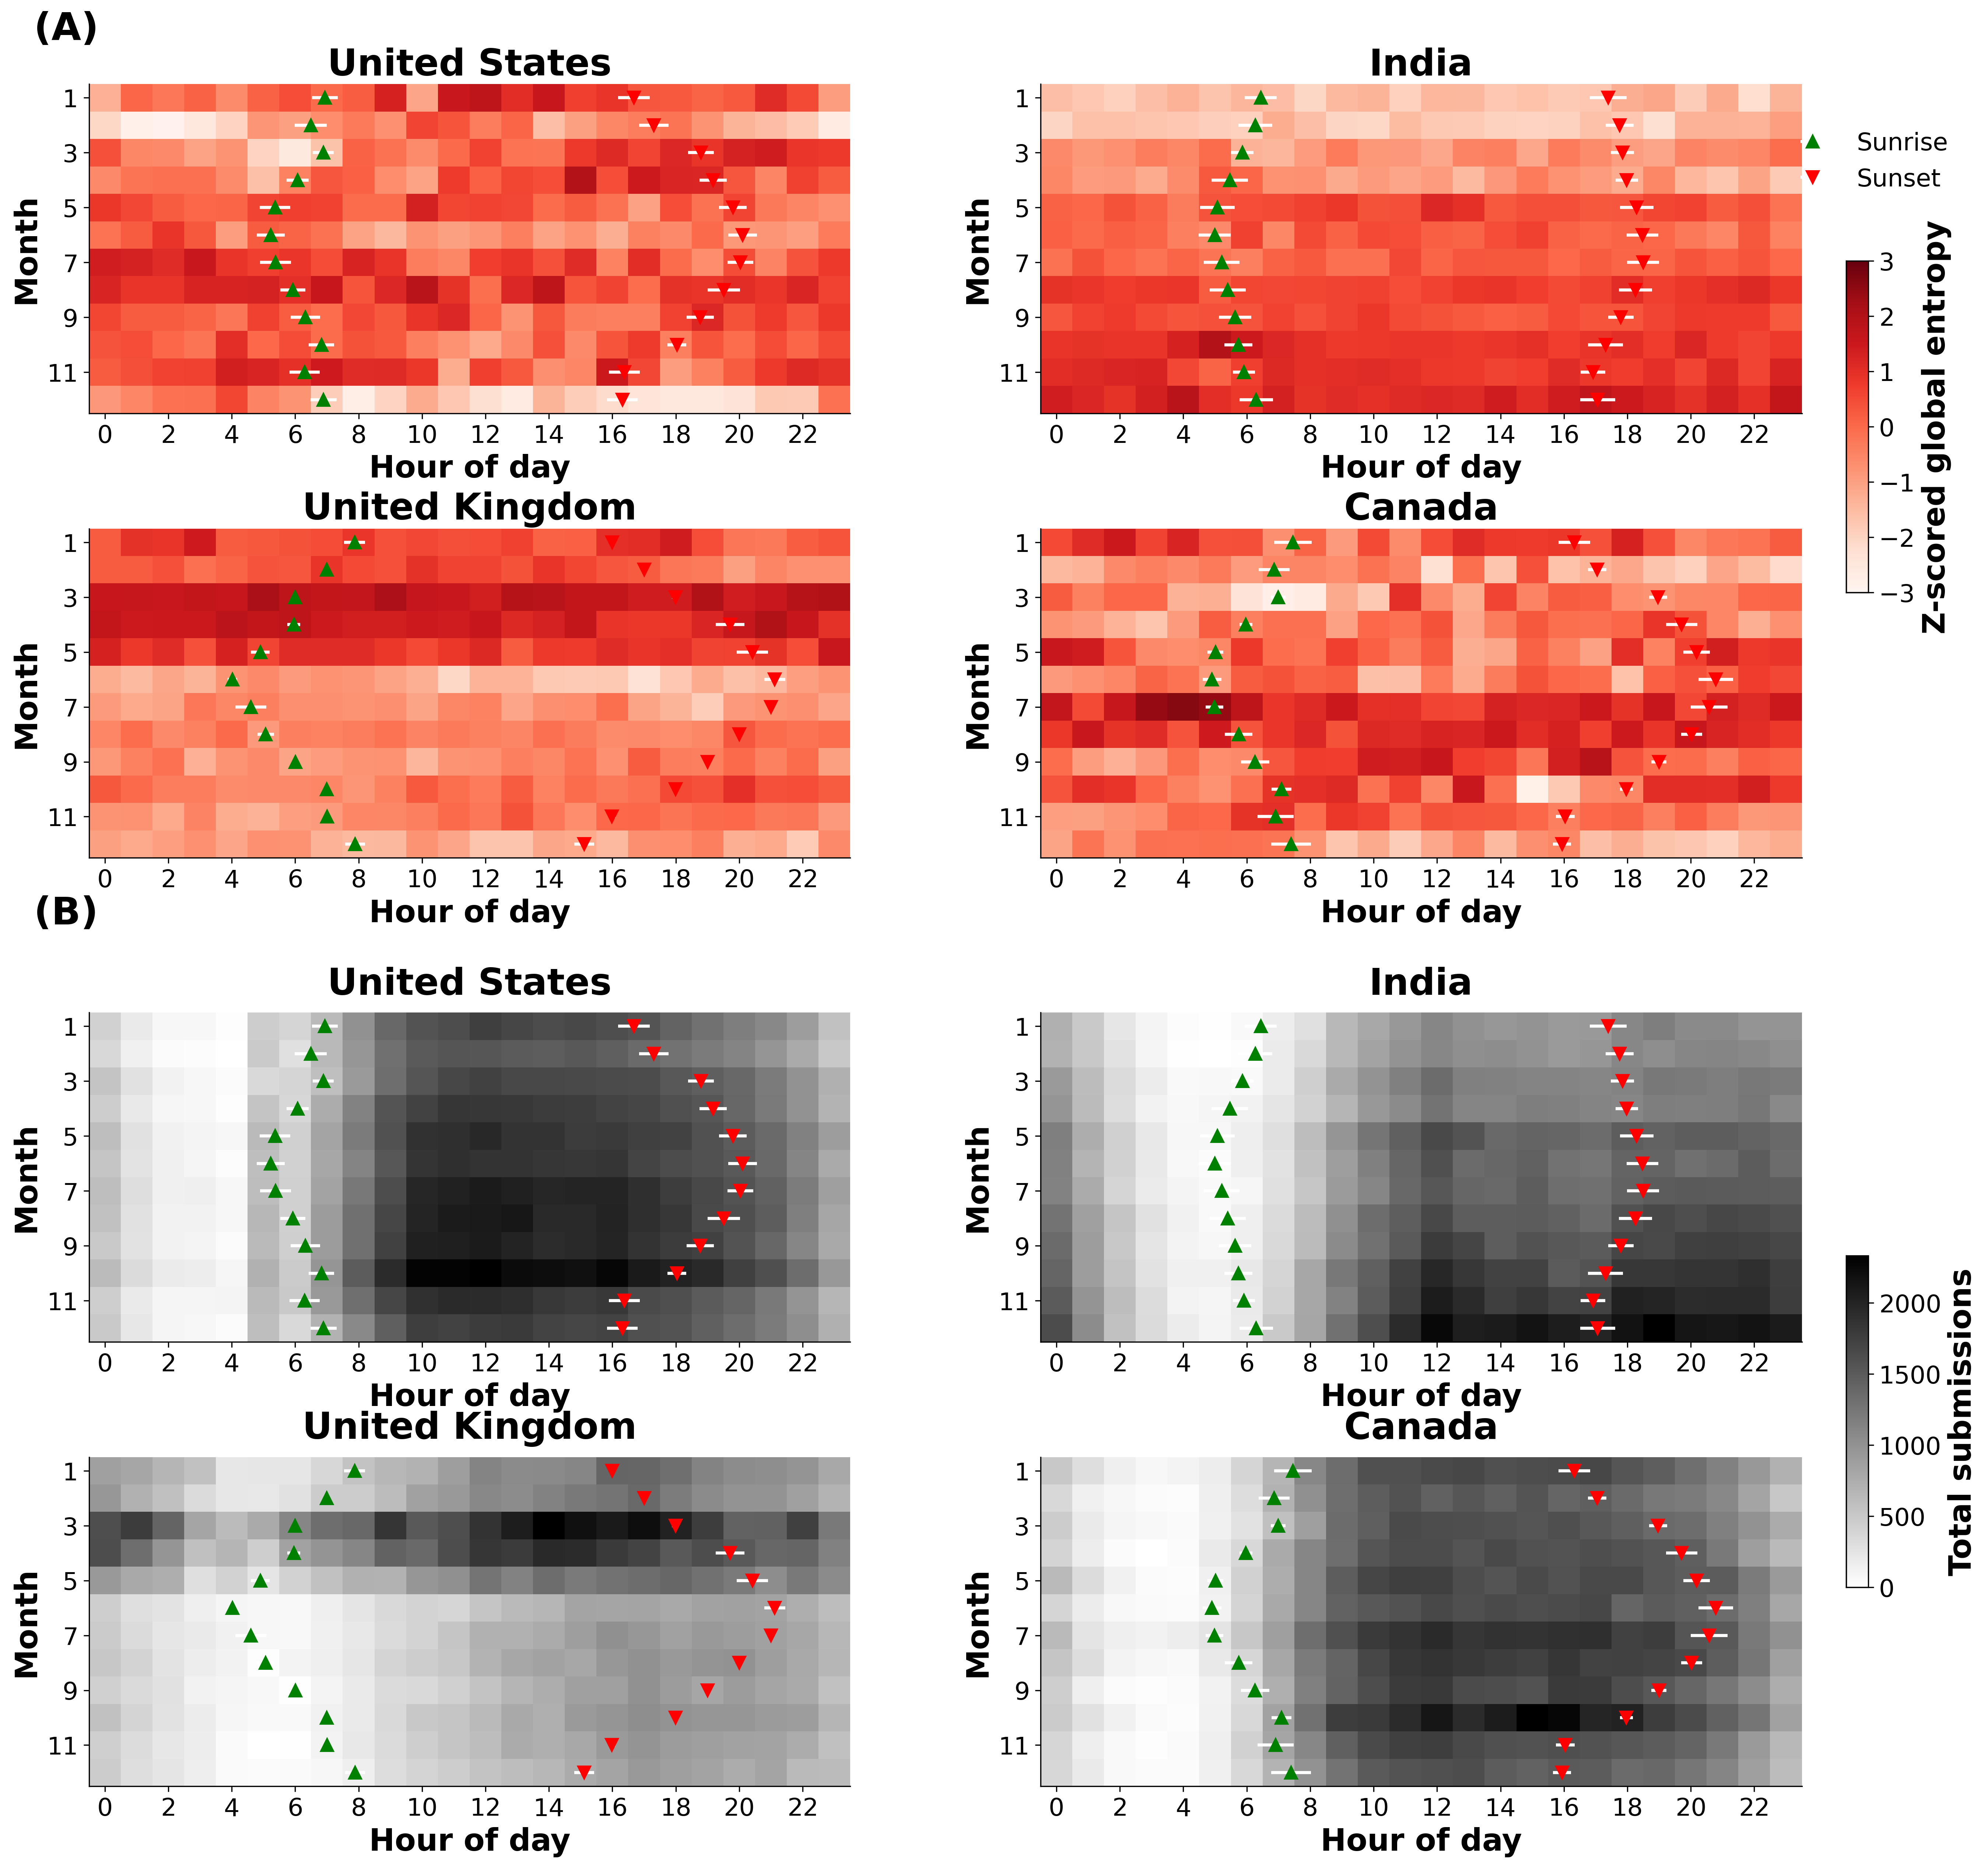

In [ ]:
n_rows, n_cols = 2, 2
fig = plt.figure(figsize=(20, 20), dpi=300)
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.2)

font_size_title = 24
font_size_labels = 20
font_size_ticks = 16
marker_size = 8
vmin_entropy, vmax_entropy = -3, 3

# ============================================================
# PANEL (A): Global semantic entropy heatmap with sunrise/sunset
# ============================================================
gs_A = gs[0].subgridspec(n_rows, n_cols, wspace=0.25, hspace=0.35)
axes_A = [fig.add_subplot(gs_A[i, j]) for i in range(n_rows) for j in range(n_cols)]

for ax, country in zip(axes_A, countries_to_plot):
    sub = global_df[global_df['loc_country'] == country]

    # Heatmap per month x hour
    heatmap_data = sub.groupby(['month', 'local_hour'])['global_entropy'].mean().unstack()
    heatmap_data = heatmap_data.reindex(index=range(1, 13), columns=range(24))

    # Z-score normalization
    heatmap_data_norm = pd.DataFrame(
        zscore(heatmap_data.values, nan_policy='omit'),
        index=heatmap_data.index,
        columns=heatmap_data.columns
    )

    # Plot heatmap
    sns.heatmap(
        heatmap_data_norm,
        ax=ax,
        cmap="Reds",
        linewidths=0,
        vmin=vmin_entropy,
        vmax=vmax_entropy,
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )

    # Overlay sunrise/sunset with SEM
    sun_stats = sun_df[sun_df.loc_country == country].groupby('month').agg({
        'sunrise_hour': ['mean', 'std'],
        'sunset_hour': ['mean', 'std']
    }).reset_index()
    sun_stats.columns = ['month', 'sunrise_mean', 'sunrise_std', 'sunset_mean', 'sunset_std']

    for _, sun_row in sun_stats.iterrows():
        month = sun_row['month']
        ax.errorbar(
            sun_row['sunrise_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunrise_std'] if not np.isnan(sun_row['sunrise_std']) else 0,
            fmt='^',
            color='green',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunrise' if month == 1 else ""
        )
        ax.errorbar(
            sun_row['sunset_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunset_std'] if not np.isnan(sun_row['sunset_std']) else 0,
            fmt='v',
            color='red',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunset' if month == 1 else ""
        )

    # Remove axis lines
    # ax.axis('off')
    ax.set_title(f"{country}", fontsize=font_size_title, fontweight='bold')
    ax.set_ylabel("Month", fontsize=font_size_labels, fontweight='bold')
    ax.set_yticks(np.arange(0.5, 12.5, 2))
    ax.set_yticklabels(range(1, 13, 2), rotation=0, fontsize=font_size_ticks)
    ax.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight='bold')
    ax.set_xticks(np.arange(0.5, 24.5, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=0, fontsize=font_size_ticks)

# Colorbar for entropy
cbar_ax = fig.add_axes([0.92, 0.65, 0.01, 0.15])
smo_entropy = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin_entropy, vmax=vmax_entropy))
smo_entropy.set_array([])
cbar_entropy = fig.colorbar(smo_entropy, cax=cbar_ax)
cbar_entropy.set_label('Z-scored global entropy', fontsize=font_size_labels, fontweight='bold')
cbar_entropy.ax.tick_params(labelsize=font_size_ticks)

# ============================================================
# PANEL (B): Total submissions heatmap with sunrise/sunset
# ============================================================
gs_B = gs[1].subgridspec(n_rows, n_cols, wspace=0.25, hspace=0.35)
axes_B = [fig.add_subplot(gs_B[i, j]) for i in range(n_rows) for j in range(n_cols)]

for ax, country in zip(axes_B, countries_to_plot):
    sub = global_df[global_df['loc_country'] == country]

    # Heatmap per month x hour
    posts_data = sub.groupby(['month', 'local_hour'])['n_posts'].sum().unstack()
    posts_data = posts_data.reindex(index=range(1, 13), columns=range(24))

    # Plot heatmap
    sns.heatmap(
        posts_data,
        ax=ax,
        cmap="gray_r",
        linewidths=0,
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )

    # Overlay sunrise/sunset with SEM
    sun_stats = sun_df[sun_df.loc_country == country].groupby('month').agg({
        'sunrise_hour': ['mean', 'std'],
        'sunset_hour': ['mean', 'std']
    }).reset_index()
    sun_stats.columns = ['month', 'sunrise_mean', 'sunrise_std', 'sunset_mean', 'sunset_std']

    for _, sun_row in sun_stats.iterrows():
        month = sun_row['month']
        ax.errorbar(
            sun_row['sunrise_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunrise_std'] if not np.isnan(sun_row['sunrise_std']) else 0,
            fmt='^',
            color='green',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunrise' if month == 1 else ""
        )
        ax.errorbar(
            sun_row['sunset_mean'] + 0.5,
            month - 0.5,
            xerr=sun_row['sunset_std'] if not np.isnan(sun_row['sunset_std']) else 0,
            fmt='v',
            color='red',
            ecolor='white',
            elinewidth=2,
            markersize=marker_size,
            label='Sunset' if month == 1 else ""
        )

    # Remove axis lines
    ax.set_title(f"{country}", fontsize=font_size_title, fontweight='bold')
    ax.set_ylabel("Month", fontsize=font_size_labels, fontweight='bold')
    ax.set_yticks(np.arange(0.5, 12.5, 2))
    ax.set_yticklabels(range(1, 13, 2), rotation=0, fontsize=font_size_ticks)
    ax.set_xlabel("Hour of day", fontsize=font_size_labels, fontweight='bold')
    ax.set_xticks(np.arange(0.5, 24.5, 2))
    ax.set_xticklabels(range(0, 24, 2), rotation=0, fontsize=font_size_ticks)
    ax.set_title(f"{country}", fontsize=font_size_title, fontweight='bold', pad=12)

# Colorbar for submissions
cbar_ax2 = fig.add_axes([0.92, 0.2, 0.01, 0.15])
# fig.add_axes([0.92, 0.65, 0.01, 0.15])
smo_posts = plt.cm.ScalarMappable(cmap="gray_r", norm=plt.Normalize(vmin=0, vmax=posts_data.max().max()))
smo_posts.set_array([])
cbar_posts = fig.colorbar(smo_posts, cax=cbar_ax2)
cbar_posts.set_label('Total submissions', fontsize=font_size_labels, fontweight='bold')
cbar_posts.ax.tick_params(labelsize=font_size_ticks)

# Legend for sunrise/sunset (panel A)
legend_ax = fig.add_axes([0.92, 0.82, 0.02, 0.05])
handles, labels = axes_A[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, frameon=False, fontsize=16, loc='center')
legend_ax.axis('off')

sns.despine()
plt.tight_layout(rect=[0, 0.05, 0.9, 1])

fig.text(0.1, 0.9, "(A)", fontsize=25, fontweight="bold")
fig.text(0.1, 0.5, "(B)", fontsize=25, fontweight="bold")

plt.savefig("figS3.png")

C:\Users\user\AppData\Local\Temp\ipykernel_20180\3604479576.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


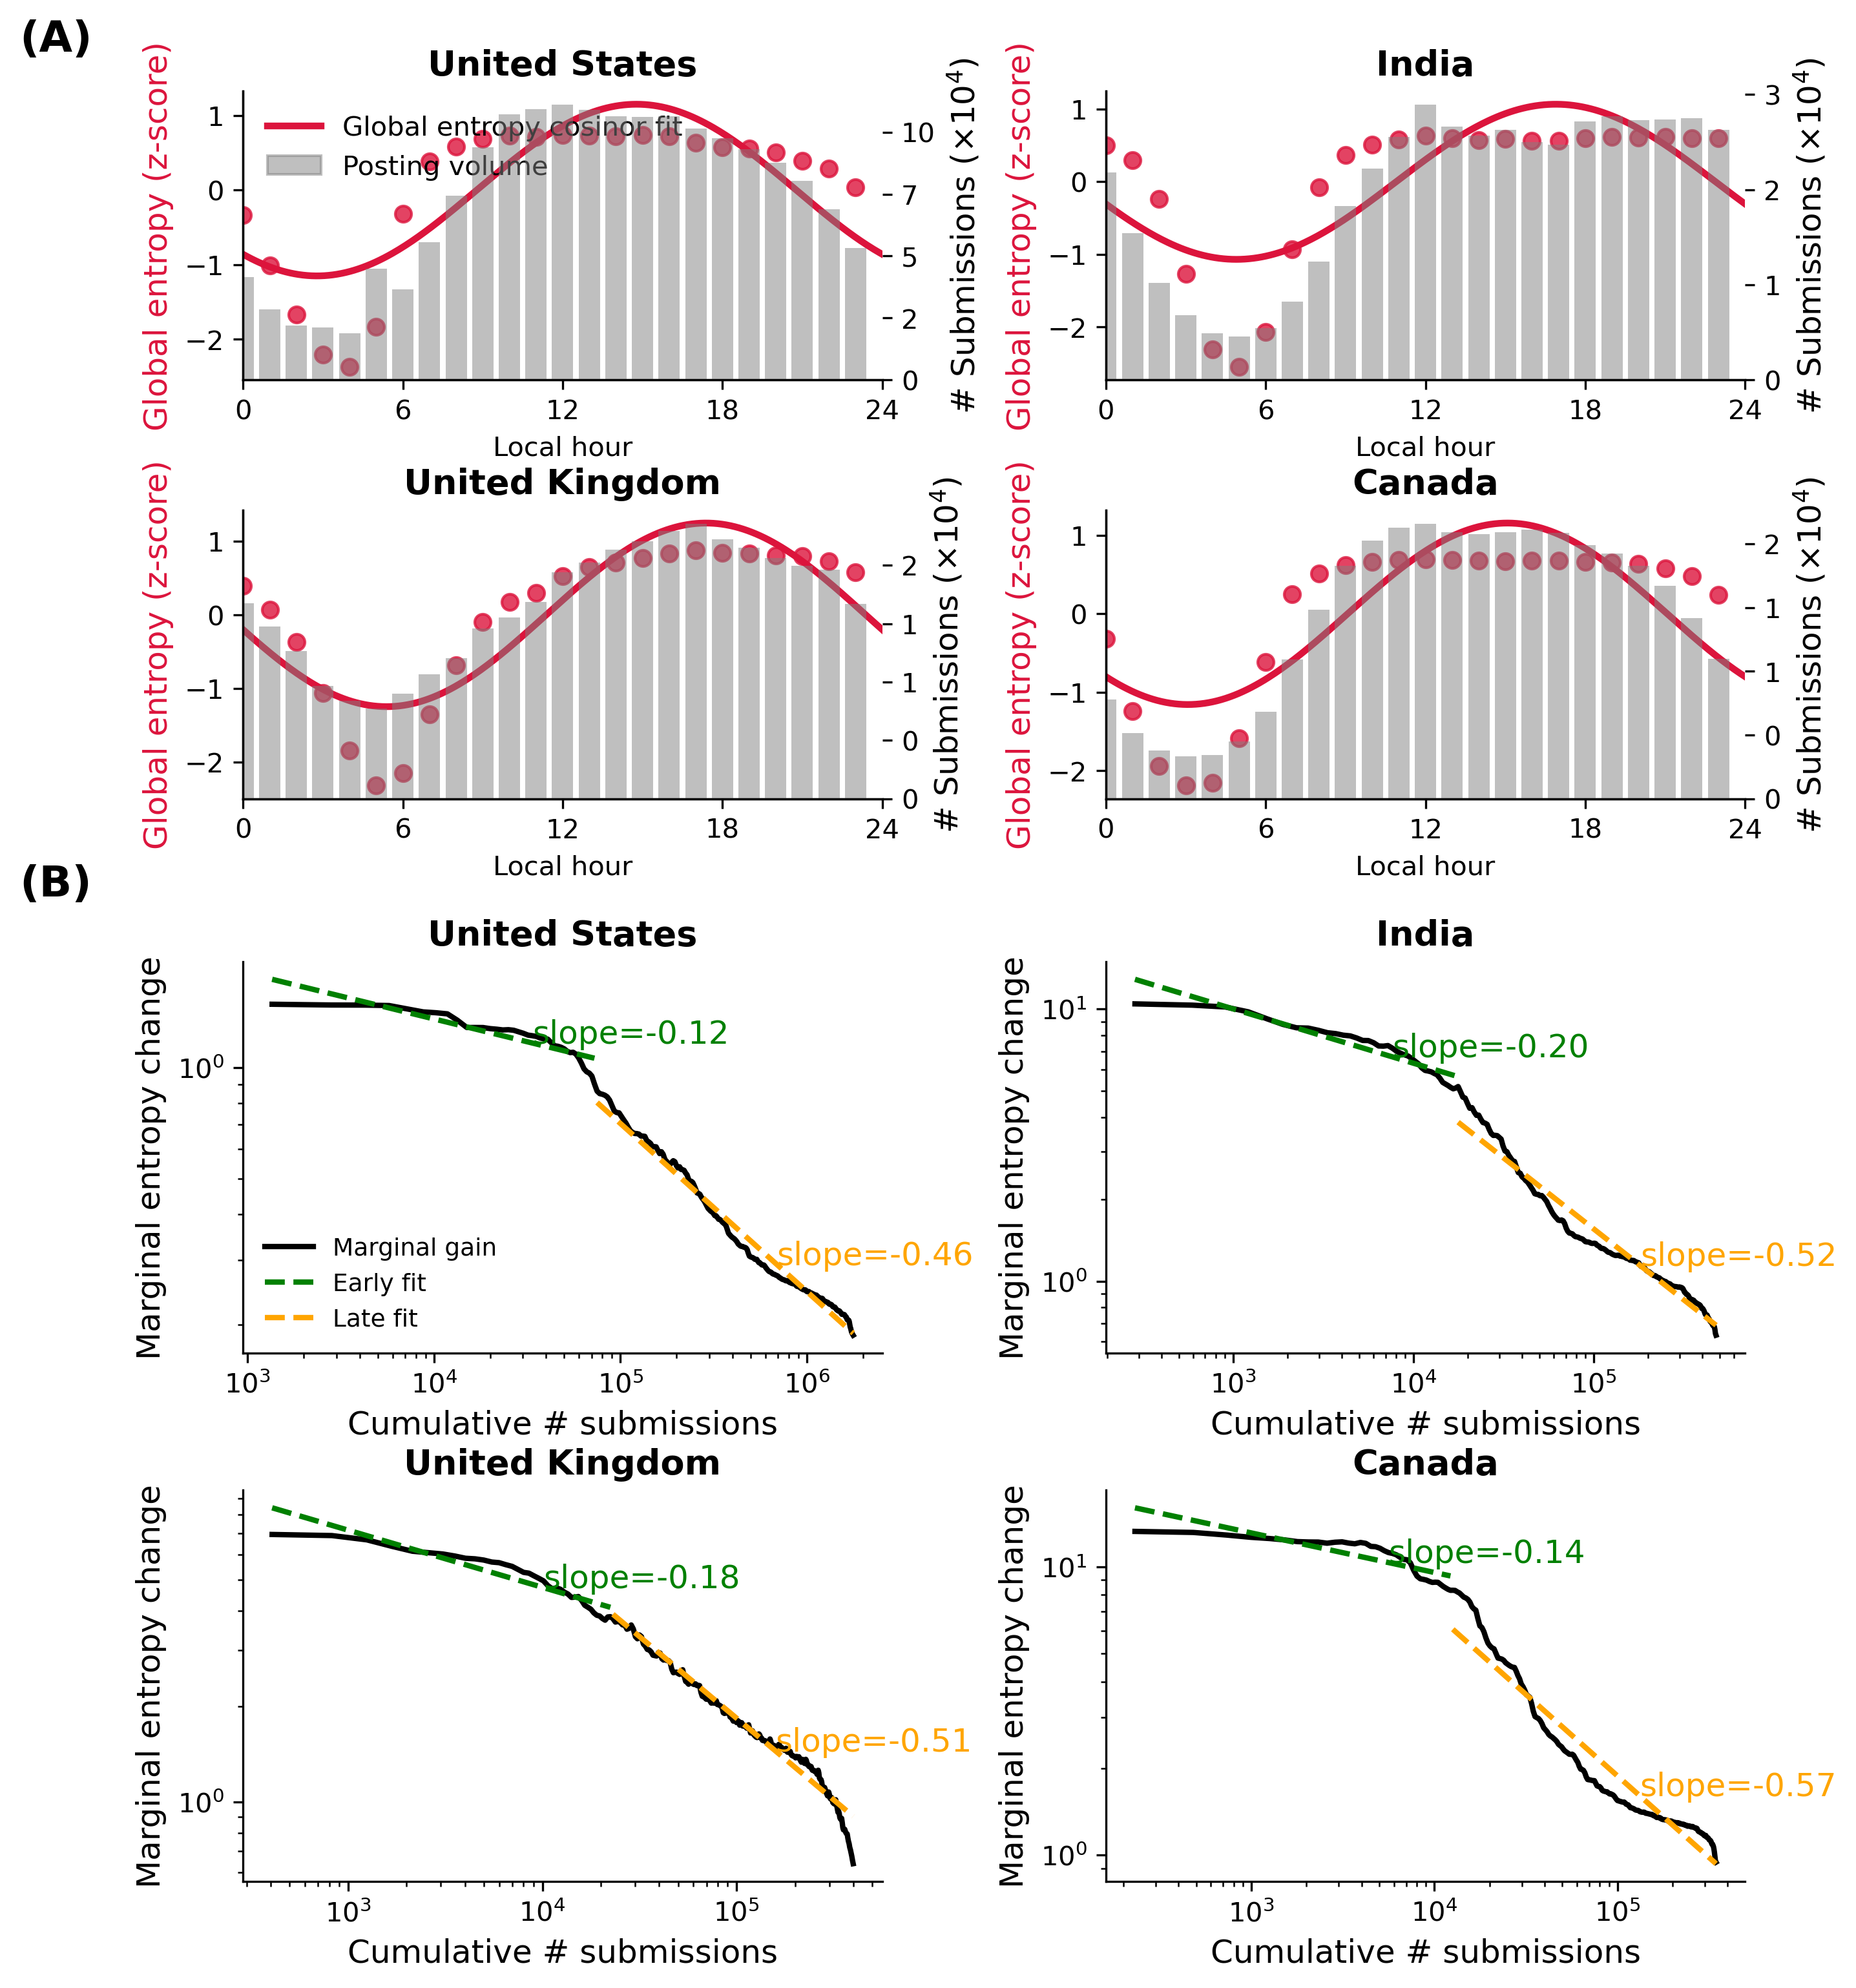

In [ ]:
# ============================================================
# Create figure layout: Panel A (top), Panel B (bottom)
# ============================================================
fig = plt.figure(figsize=(10, 12), dpi=300)
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.3], hspace=0.2)

# ============================================================
# ======================= PANEL (A) ==========================
# Cosinor fit for global entropy, posts as bar plot
# ============================================================
gs_A = gs[0].subgridspec(2, 2, wspace=0.35, hspace=0.45)
axes_A = [fig.add_subplot(gs_A[i, j]) for i in range(2) for j in range(2)]

for ax, country in zip(axes_A, countries_to_plot):

    sub = global_df[
        (global_df["loc_country"] == country) &
        (~global_df["local_hour"].isna()) &
        (~global_df["global_entropy"].isna()) &
        (~global_df["n_posts"].isna())
    ]

    # Hourly aggregation
    H = sub.groupby("local_hour")["global_entropy"].mean().reindex(range(24))
    N = sub.groupby("local_hour")["n_posts"].sum().reindex(range(24))

    mask = H.notna() & N.notna()
    if mask.sum() < 6:
        ax.axis("off")
        continue

    t = H.index.values[mask]
    H_z = zscore(H.values[mask])
    N_vals = N.values[mask]  # raw post counts for bar height

    # Cosinor fit only for global entropy
    res_H = cosinor_24h_mean(t, H_z)
    mesor_H = res_H["model"].params[0]

    t_fine = np.linspace(0, 24, 300)
    omega = 2 * np.pi / 24
    H_fit = mesor_H + res_H["amplitude"] * np.cos(
        omega * (t_fine - res_H["phase_h"])
    )

    # ---- Plot cosinor for entropy ----
    ax.plot(t, H_z, "o", color="crimson", alpha=0.8)
    ax.plot(t_fine, H_fit, color="crimson", lw=2.5, label="Global entropy cosinor fit")
    ax.set_ylabel("Global entropy (z-score)", color="crimson", fontsize=12)
    ax.set_xlabel("Local hour")
    ax.set_xlim(0, 24)
    ax.set_xticks(np.arange(0, 25, 6))
    ax.spines["top"].set_visible(False)

    # ---- Twin axis for posting volume ----
    # Twin axis for posting volume as barplot
    ax2 = ax.twinx()
    ax2.bar(t, N_vals, width=0.8, color="gray", alpha=0.5, label="#Submissions")
    
    # Format ticks to show in 'k' (thousands)
    ax2.get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, _: f"{int(x/10000)}")
    )
    ax2.set_ylabel(r"# Submissions ($\times 10^4$)", fontsize=12)
    
    # Optional: keep the spine
    ax2.spines["right"].set_visible(True)

    ax.set_title(country, fontsize=13, fontweight="bold")

# ---- Single legend for Panel A ----
axes_A[0].legend(
    handles=[
        plt.Line2D([], [], color="crimson", lw=2.5, label="Global entropy cosinor fit"),
        plt.Rectangle((0,0),1,1, color="gray", alpha=0.5, label="Posting volume"),
    ],
    frameon=False,
    fontsize=10,
    loc="upper left"
)

axes_A[0].text(
    -0.35, 1.25, "(A)",
    transform=axes_A[0].transAxes,
    fontsize=16, fontweight="bold", va="top"
)

# ============================================================
# ======================= PANEL (B) ==========================
# Diminishing returns / power-law scaling
# ============================================================
gs_B = gs[1].subgridspec(2, 2, wspace=0.35, hspace=0.35)
axes_B = [fig.add_subplot(gs_B[i, j]) for i in range(2) for j in range(2)]

show_legend = True

for ax, country in zip(axes_B, countries_to_plot):

    sub = global_df[global_df["loc_country"] == country]

    H = (
        sub.groupby(["month", "local_hour"])["global_entropy"]
        .mean()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    N = (
        sub.groupby(["month", "local_hour"])["n_posts"]
        .sum()
        .unstack()
        .reindex(index=range(1, 13), columns=range(24))
    )

    x = N.values.flatten()
    H = H.values.flatten()

    mask = (~np.isnan(x)) & (~np.isnan(H)) & (x > 0)
    if mask.sum() < 30:
        ax.axis("off")
        continue

    x = x[mask]
    E = -H[mask]

    order = np.argsort(x)
    x = x[order]
    E = E[order]

    cum_posts = np.cumsum(x)
    cum_entropy = np.cumsum(E)

    marginal_gain = np.gradient(cum_entropy, cum_posts)

    mid = len(marginal_gain) // 7
    c1, c2 = cum_posts[:mid], cum_posts[mid:]
    g1, g2 = marginal_gain[:mid], marginal_gain[mid:]

    s1, i1, _, _, _ = linregress(np.log10(c1), np.log10(g1))
    s2, i2, _, _, _ = linregress(np.log10(c2), np.log10(g2))

    ax.plot(cum_posts, marginal_gain, color="k", lw=2, label="Marginal gain")
    ax.plot(c1, 10**i1 * c1**s1, "--", color="green", lw=2, label="Early fit")
    ax.plot(c2, 10**i2 * c2**s2, "--", color="orange", lw=2, label="Late fit")

    ax.text(
        c1[len(c1)//2], (10**i1 * c1**s1)[len(c1)//2],
        f"slope={s1:.2f}", color="green", fontsize=12
    )
    ax.text(
        c2[len(c2)//2], (10**i2 * c2**s2)[len(c2)//2],
        f"slope={s2:.2f}", color="orange", fontsize=12
    )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(country, fontsize=13, fontweight="bold")
    ax.set_xlabel("Cumulative # submissions", fontsize=12)
    ax.set_ylabel("Marginal entropy change", fontsize=12)

    if show_legend:
        ax.legend(frameon=False, fontsize=9)
        show_legend = False

axes_B[0].text(
    -0.35, 1.25, "(B)",
    transform=axes_B[0].transAxes,
    fontsize=16, fontweight="bold", va="top"
)

sns.despine()
plt.tight_layout()
plt.savefig("Figure5.png")